In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv 
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from tqdm import tqdm

# Reading Data

In [2]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [3]:
read_query = make_read_query()

In [4]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



id  age gender         country          city traffic_source  \
0  56219   60      F   United States  Philadelphia       Facebook   
1   9418   69      F  United Kingdom       Cardiff         Search   
2  21731   65      F           China        Harbin          Email   
3  39594   17      M           China      Shenzhen         Search   
4   2000   30      F           China         Hefei         Search   

           created_at first_order_timestamp last_order_timestamp  \
0 2019-01-02 00:06:00   2021-05-27 23:07:12  2021-05-27 23:07:12   
1 2019-01-02 00:36:00   2021-07-30 12:35:12  2023-04-21 14:50:59   
2 2019-01-02 01:47:00   2023-09-17 22:23:37  2023-09-17 22:23:37   
3 2019-01-02 03:00:00   2019-02-11 03:06:43  2019-10-25 02:29:03   
4 2019-01-02 03:19:00                   NaT                  NaT   

   days_to_activation  ...                   fav_category  fav_cat_purchases  \
0               876.0  ...                          Jeans                1.0   
1               940.0  ...              Outerwear & Coats                1.0   
2              1719.0  ...              Blazers & Jackets                1.0   
3                40.0  ...  Fashion Hoodies & Sweatshirts                1.0   
4                 NaN  ...                           None                NaN   

   fav_cat_avg_item_value  fav_cat_freq_strength  fav_cat_spending_strength  \
0                   74.99                   0.00                   0.000000   
1                  399.00                   0.50                   0.900677   
2                  169.98                   0.25                   0.696811   
3                   51.96                   0.50                   0.722168   
4                     NaN                    NaN                        NaN   

                                         order_items  \
0  {"(70373,\"WranglerÂ® Booty Up Stretch Jean fo...   
1  {"(90353,\"Colleen Skirt Slip\",Women,Intimate...   
2  {"(27173,\"Modadorn New Arrivals Spring & fall...   
3  {"(49470,\"Billabong Men's Semi-Button Up Stri...   
4                                               None   

                            loyalty_segment        order_value_segment  \
0                        One-Off Purchasers                       None   
1  New Repeat Customer (High Days-to-Order)  Ordering High Value Items   
2                        One-Off Purchasers                       None   
3   New Repeat Customer (Mid Days-to-Order)         Ordering Low Value   
4                             Never Ordered                       None   

   category_choice_segment  lifetime_status  
0                     None             None  
1                     None             None  
2                     None             None  
3                     None             None  
4                     None             None  

[5 rows x 32 columns]

In [5]:
order_items_enriched = read_query("SELECT * FROM order_items_enriched")
order_items_enriched.head()

SELECT * FROM order_items_enriched 



id  order_id  user_id  product_id  inventory_item_id      status  \
0   1         1        1        2953                  3     Shipped   
1   2         1        1        4731                  7     Shipped   
2   3         1        1        7656                  9     Shipped   
3   4         2        2       25774                 11    Complete   
4   5         3        3       22308                 13  Processing   

           created_at          shipped_at        delivered_at returned_at  \
0 2022-07-20 10:32:05 2022-07-20 16:42:00                 NaT         NaT   
1 2022-07-20 11:05:38 2022-07-20 16:42:00                 NaT         NaT   
2 2022-07-19 11:29:28 2022-07-20 16:42:00                 NaT         NaT   
3 2022-02-20 10:28:57 2022-02-22 12:23:00 2022-02-23 18:29:00         NaT   
4 2023-04-23 09:04:57                 NaT                 NaT         NaT   

   ...   product_category  product_department    product_brand  \
0  ...             Active               Women   Tommy Hilfiger   
1  ...              Jeans               Women      Joe's Jeans   
2  ...  Blazers & Jackets               Women  eVogues Apparel   
3  ...          Underwear                 Men     Tommy Bahama   
4  ...              Pants                 Men          Dockers   

                                        product_name  \
0          Tommy Hilfiger Women's 3 Pack Sports Crew   
1                   Joe's Jeans Women's Skinny Jeans   
2  Plus size Button Closure Cropped Bolero Jacket...   
3            Tommy Bahama Tropical Print Boxer Short   
4  Dockers Men's Limited Offer D2 Stretch Khaki Pant   

                           distribution_center user_age user_gender  \
0                                   Memphis TN       62           F   
1  Port Authority of New York/New Jersey NY/NJ       62           F   
2                               New Orleans LA       62           F   
3                               Los Angeles CA       65           M   
4                              Philadelphia PA       16           M   

     user_county         user_city user_traffic_source  
0    South Korea      Bucheon City              Search  
1    South Korea      Bucheon City              Search  
2    South Korea      Bucheon City              Search  
3         Brasil            Franca             Organic  
4  United States  Hallandale Beach             Organic  

[5 rows x 22 columns]

In [6]:
order_items_enriched.columns

Index(['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price', 'cost', 'product_category', 'product_department',
       'product_brand', 'product_name', 'distribution_center', 'user_age',
       'user_gender', 'user_county', 'user_city', 'user_traffic_source'],
      dtype='object')

In [7]:
order_items_enriched.product_category.unique()

array(['Active', 'Jeans', 'Blazers & Jackets', 'Underwear', 'Pants',
       'Sleep & Lounge', 'Swim', 'Sweaters', 'Skirts', 'Shorts',
       'Accessories', 'Fashion Hoodies & Sweatshirts',
       'Suits & Sport Coats', 'Tops & Tees', 'Socks', 'Outerwear & Coats',
       'Dresses', 'Jumpsuits & Rompers', 'Maternity', 'Intimates',
       'Pants & Capris', 'Leggings', 'Plus', 'Socks & Hosiery', 'Suits',
       'Clothing Sets'], dtype=object)

In [8]:
order_items_enriched.status.value_counts()

status
Shipped       54440
Complete      45609
Processing    36388
Cancelled     27090
Returned      18232
Name: count, dtype: int64

# Calculating Features

In [9]:
def user_item_matrix(order_items_enriched: pd.DataFrame, columns: str, user_gender: str = None) -> pd.DataFrame:
    order_items_filtered = order_items_enriched.loc[~order_items_enriched.status.isin(['Cancelled', 'Returned'])]

    if user_gender:
        order_items_filtered = order_items_filtered.loc[order_items_enriched.user_gender==user_gender]
                                              
                                 
    X_cats = order_items_filtered.pivot_table(index='user_id', 
                                              columns=columns, 
                                              values='id', 
                                              aggfunc='count', 
                                              fill_value=0)
    
    return X_cats

In [10]:
X_cats_m = user_item_matrix(order_items_enriched, 'product_category', 'M')
X_cats_f = user_item_matrix(order_items_enriched, 'product_category', 'F')

In [11]:
print('Category Purchases Male', f'Columns: {X_cats_m.columns}', f'Shape: {X_cats_m.shape}', sep='\n')
print('\nCategory Purchases Female', f'Columns: {X_cats_f.columns}', f'Shape: {X_cats_f.shape}', sep='\n')

Category Purchases Male
Columns: Index(['Accessories', 'Active', 'Fashion Hoodies & Sweatshirts', 'Jeans',
       'Outerwear & Coats', 'Pants', 'Shorts', 'Sleep & Lounge', 'Socks',
       'Suits & Sport Coats', 'Sweaters', 'Swim', 'Tops & Tees', 'Underwear'],
      dtype='object', name='product_category')
Shape: (33080, 14)

Category Purchases Female
Columns: Index(['Accessories', 'Active', 'Blazers & Jackets', 'Clothing Sets',
       'Dresses', 'Fashion Hoodies & Sweatshirts', 'Intimates', 'Jeans',
       'Jumpsuits & Rompers', 'Leggings', 'Maternity', 'Outerwear & Coats',
       'Pants & Capris', 'Plus', 'Shorts', 'Skirts', 'Sleep & Lounge',
       'Socks & Hosiery', 'Suits', 'Sweaters', 'Swim', 'Tops & Tees'],
      dtype='object', name='product_category')
Shape: (33174, 22)


# Collaborative Filtering for Category Recommendations

In [12]:
def apply_collaborative_filtering(user_item_ratings: pd.DataFrame,
                                 encodings: pd.DataFrame = None,
                                 kind = 'user'):
    if kind == 'user':
        encodings = user_item_ratings if encodings is None else encodings
        encodings_norm = np.apply_along_axis(lambda x: x / np.sqrt(x @ x), 1, encodings)
        similarities = encodings_norm @ encodings_norm.T
        expected_ratings = similarities @ user_item_ratings / np.sum(similarities, axis=1).reshape(-1, 1)
    elif kind == 'item':
        encodings = user_item_ratings.T if encodings is None else encodings
        encodings_norm = np.apply_along_axis(lambda x: x / np.sqrt(x @ x), 1, encodings)
        similarities = encodings_norm @ encodings_norm.T
        expected_ratings = user_item_ratings @ similarities / np.sum(similarities, axis=0)

    expected_ratings.index = user_item_ratings.index
    expected_ratings.columns = user_item_ratings.columns
        
    return expected_ratings

In [13]:
def filter_recommendations(expected_ratings, min_rating=0, top_k=None):
    def filter_row(row):
        row = row.loc[row>min_rating].sort_values(ascending=False)
        row = row.iloc[:top_k] if top_k else row
        return list(row.to_dict().items())
        
    recommendations = expected_ratings.apply(filter_row, axis=1)
    recommendations.name = 'recommendations'
    return recommendations

In [14]:
def exploded_recommendation_as_row(row):
    recommendation = row['recommendations']
    
    if pd.isna(recommendation):
        return row

    recommendation_tuple = tuple(recommendation)
    recommendation_row = pd.Series({
        'category': recommendation_tuple[0],
        'rating': recommendation_tuple[1]
    })
    
    return recommendation_row

def explode_recommendations(recommendations):
    recommendations_exploded = recommendations.explode().to_frame().apply(exploded_recommendation_as_row, axis=1)
    return recommendations_exploded

In [15]:
def plot_categories(recommendations_exploded):
    n_users = recommendations_exploded.shape[0]
    category_counts = recommendations_exploded.category.value_counts().to_frame()
    category_percent = category_counts / n_users
    category_percent = category_percent.rename(columns={'count': 'percent'})
    category_aggs = category_counts.join(category_percent).sort_values('count', ascending=False)
    category_aggs = category_aggs.reset_index().rename(columns={'index': 'category'})
    
    ax = sns.barplot(category_aggs, x='category', y='count', hue='percent', palette='vlag')
    ax.tick_params(axis='x', labelrotation=90)
    
    for p in ax.patches:
        percentage = '{:.0f}%'.format(100 * p.get_height()/n_users)
        x = p.get_x() + p.get_width() / 2 - 0.5
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 9)

    return category_aggs

In [16]:
def plot_category_intersections(recommendations_exploded):
    recommendations_pivot = recommendations_exploded.reset_index().pivot(index='user_id', columns='category', values='rating')
    recommendation_encodings = (~recommendations_pivot.isna()).astype(int)
    
    n_users, n_categories = recommendations_pivot.shape
    categories = recommendations_pivot.columns
    intersect_percent = np.zeros((n_categories, n_categories))
    diag_bool_idx = np.diag(np.ones_like(intersect_percent)).astype(bool)
    intersect_percent[diag_bool_idx] = None
    
    for i, c1 in enumerate(categories):
        for j, c2 in enumerate(categories):
            if c1 == c2:
                continue
                
            intersect_results = recommendation_encodings.loc[(recommendation_encodings[c1]==1)&
                                                             (recommendation_encodings[c2]==1)]
            n_intersect = intersect_results.shape[0]
            intersect_percent[i,j] = n_intersect / n_users
    
    intersect_percent = pd.DataFrame(intersect_percent, index=categories, columns=categories)

    sns.heatmap(intersect_percent)
    return intersect_percent

## Female Customers

In [17]:
expected_ratings_user_f = apply_collaborative_filtering(X_cats_f, kind='user')
expected_ratings_item_f = apply_collaborative_filtering(X_cats_f, kind='item')
expected_ratings_f = (expected_ratings_user_f + expected_ratings_item_f) / 2

In [18]:
recommendations_f = filter_recommendations(expected_ratings_f, top_k=1)
recommendations_exploded_f = explode_recommendations(recommendations_f)

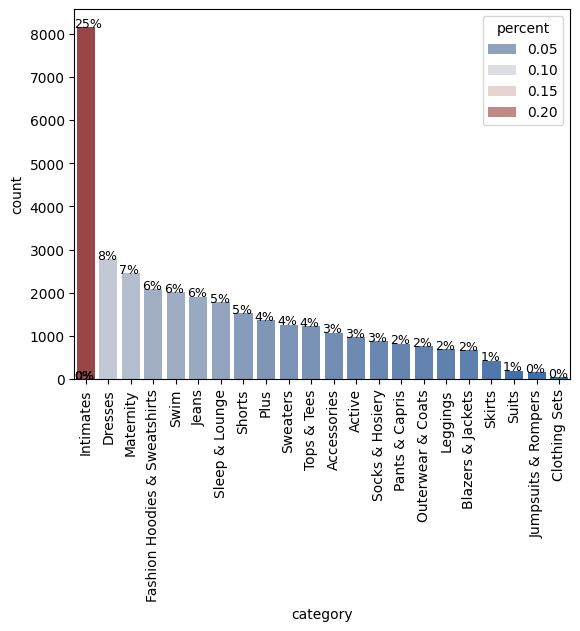

In [19]:
category_aggs = plot_categories(recommendations_exploded_f)

In [237]:
recommendations_f = filter_recommendations(expected_ratings_f, min_rating=0.05, top_k=2)
recommendations_exploded_f = explode_recommendations(recommendations_f)

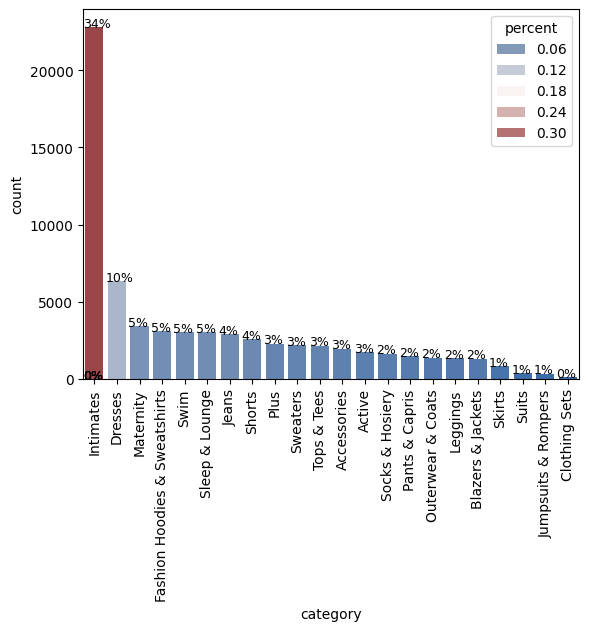

In [238]:
category_aggs = plot_categories(recommendations_exploded_f)

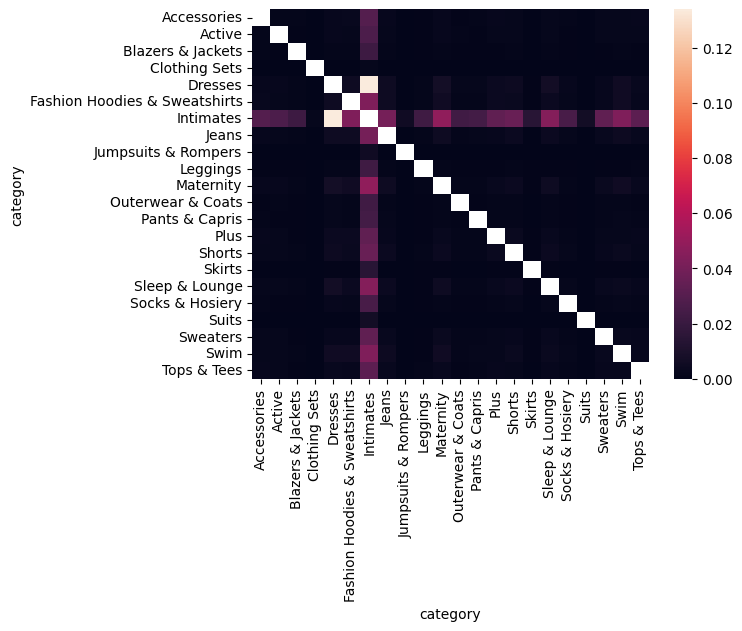

In [239]:
intersect_percent = plot_category_intersections(recommendations_exploded_f)

## Male Customers

In [23]:
expected_ratings_user_m = apply_collaborative_filtering(X_cats_m, kind='user')
expected_ratings_item_m = apply_collaborative_filtering(X_cats_m, kind='item')
expected_ratings_m = (expected_ratings_user_m + expected_ratings_item_m) / 2

In [24]:
recommendations_m = filter_recommendations(expected_ratings_m, top_k=1)
recommendations_exploded_m = explode_recommendations(recommendations_m)

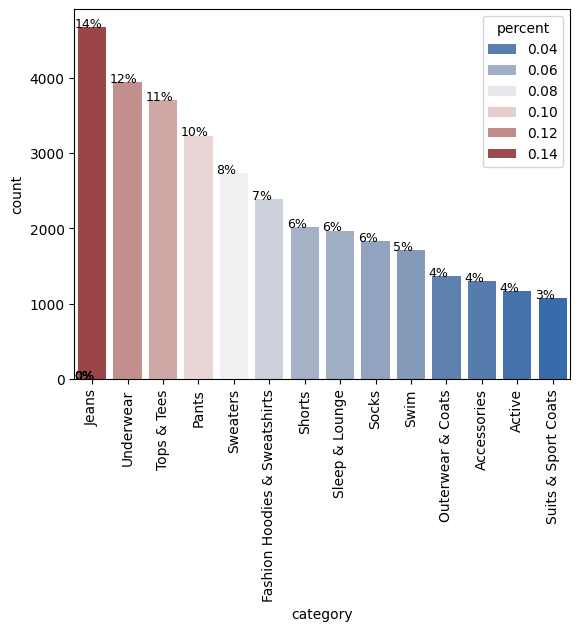

In [25]:
category_aggs = plot_categories(recommendations_exploded_m)

In [241]:
recommendations_m = filter_recommendations(expected_ratings_m, top_k=2)
recommendations_exploded_m = explode_recommendations(recommendations_m)

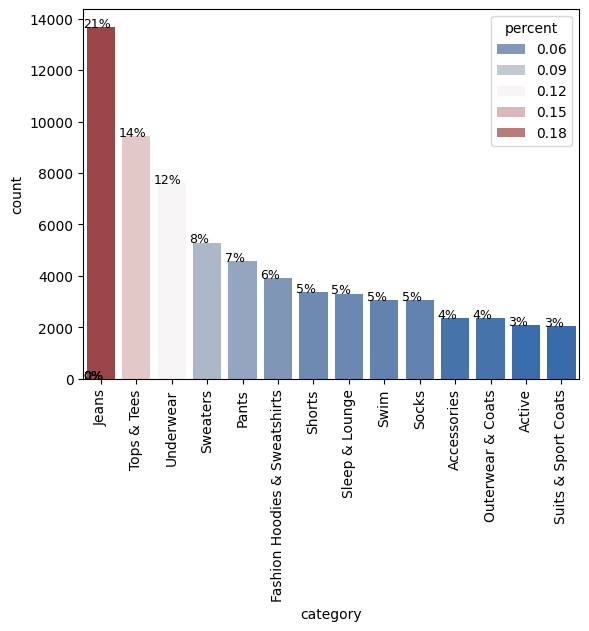

In [242]:
category_aggs = plot_categories(recommendations_exploded_m)

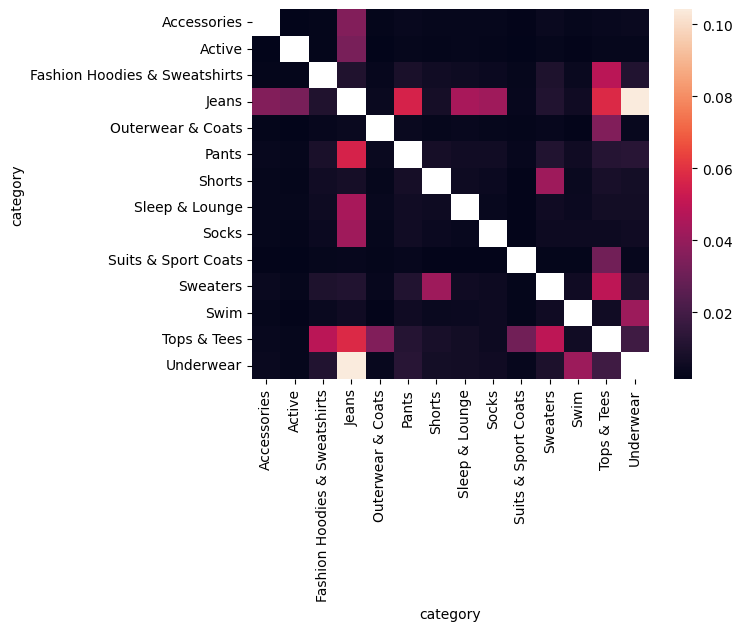

In [243]:
intersect_percent = plot_category_intersections(recommendations_exploded_m)

# Category Segments

In [555]:
def plot_category_segments(recommendations_segmented, column='percent_cumsum', top_k=20, last=False):
    category_segment_aggs = recommendations_segmented.category_segment.value_counts().to_frame()
    category_segment_aggs['percent'] = category_segment_aggs['count'] / recommendations_segmented.shape[0]
    category_segment_aggs['percent_cumsum'] = category_segment_aggs['percent'].cumsum()

    if last:
        segment_aggs_filtered = category_segment_aggs.iloc[-top_k:]
    else:
        segment_aggs_filtered = category_segment_aggs.iloc[:top_k]
        
    plt.figure(figsize=(9, 9))
    plt.title('Most Common Segments')
    ax = sns.barplot(x=segment_aggs_filtered[column], y=segment_aggs_filtered.index.to_series())

    if column == 'percent_cumsum':
        _ = ax.set_xticks(np.arange(0, 1, 0.05))

    return category_segment_aggs

In [556]:
def plot_category_segments_aov(users_enriched, top_k=20, title_suffix=None):
    segment_aov = users_enriched.groupby('category_segment').agg({'avg_order_value': ['count', 'mean', 'sum']})\
                                 .sort_values(('avg_order_value', 'sum'), ascending=False)\
                                 .reset_index()
    
    segment_aov['percent_count'] = segment_aov[('avg_order_value', 'count')] / segment_aov[('avg_order_value', 'count')].sum()
    
    
    segment_aov_ = segment_aov.sort_values(('avg_order_value', 'sum'), ascending=False).head(top_k)
    segment_aov_['cumsum_percent_count'] = segment_aov_['percent_count'].cumsum()

    title = 'Top Segments by Sum AOV'
    title += ' ' + title_suffix if title_suffix else ''
    
    fig, axs = plt.subplots(3, 1, figsize=(7, 15))
    fig.subplots_adjust(top=0.935)
    fig.suptitle(title)
    
    axs[0].set_title('Sum AOV')
    sns.barplot(segment_aov_, x=('avg_order_value', 'sum'), y='category_segment', ax=axs[0])
    
    axs[1].set_title('Mean AOV')
    sns.barplot(segment_aov_, x=('avg_order_value', 'mean'), y='category_segment', ax=axs[1])
    
    axs[2].set_title('Cum. Sum Percent. Customers')
    sns.barplot(segment_aov_, x='cumsum_percent_count', y='category_segment', ax=axs[2])

In [557]:
recommendations = pd.concat([recommendations_f, recommendations_m]).to_frame()
recommendations['category_segment'] = recommendations.recommendations.apply(
    lambda x: ', '.join(sorted([y[0] for y in x]))
)
users_enriched_new = users_enriched.join(recommendations, on='id', how='left')
category_segment_isna = users_enriched_new.category_segment.isna()
users_enriched_new.loc[category_segment_isna, 'category_segment'] = users_enriched_new.loc[category_segment_isna, 'fav_category']

## Female Customers

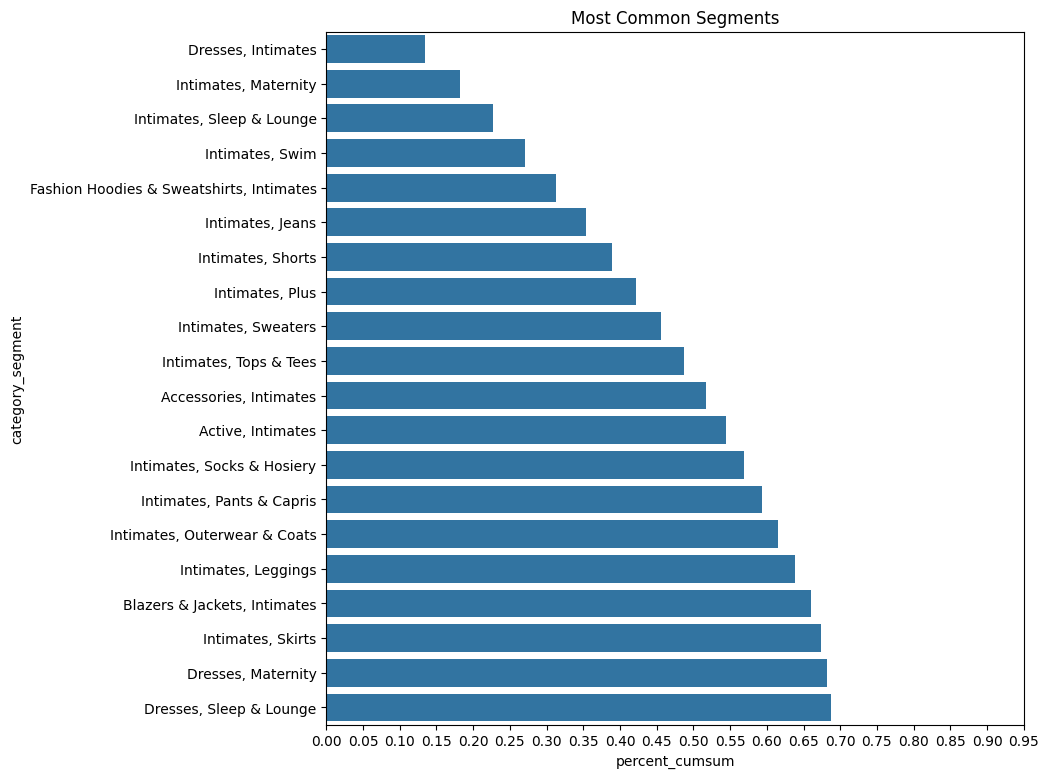

In [558]:
category_segment_aggs = plot_category_segments(recommendations_segmented_f)

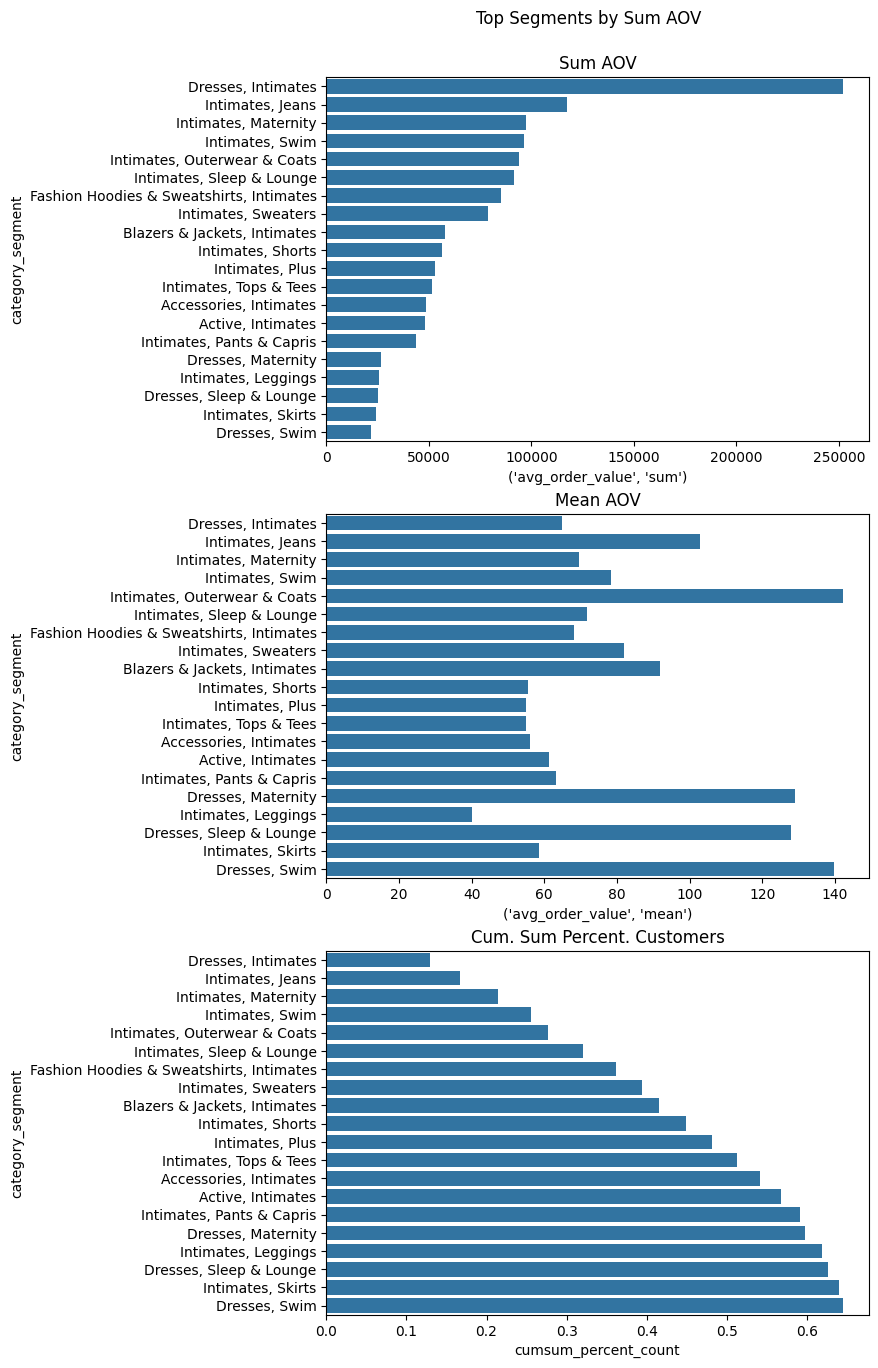

In [559]:
plot_category_segments_aov(users_enriched_new.loc[users_enriched_new.gender=='F'])

### Drill-Down by Order Value Segment

#### Multiple Mid-Value Orderers

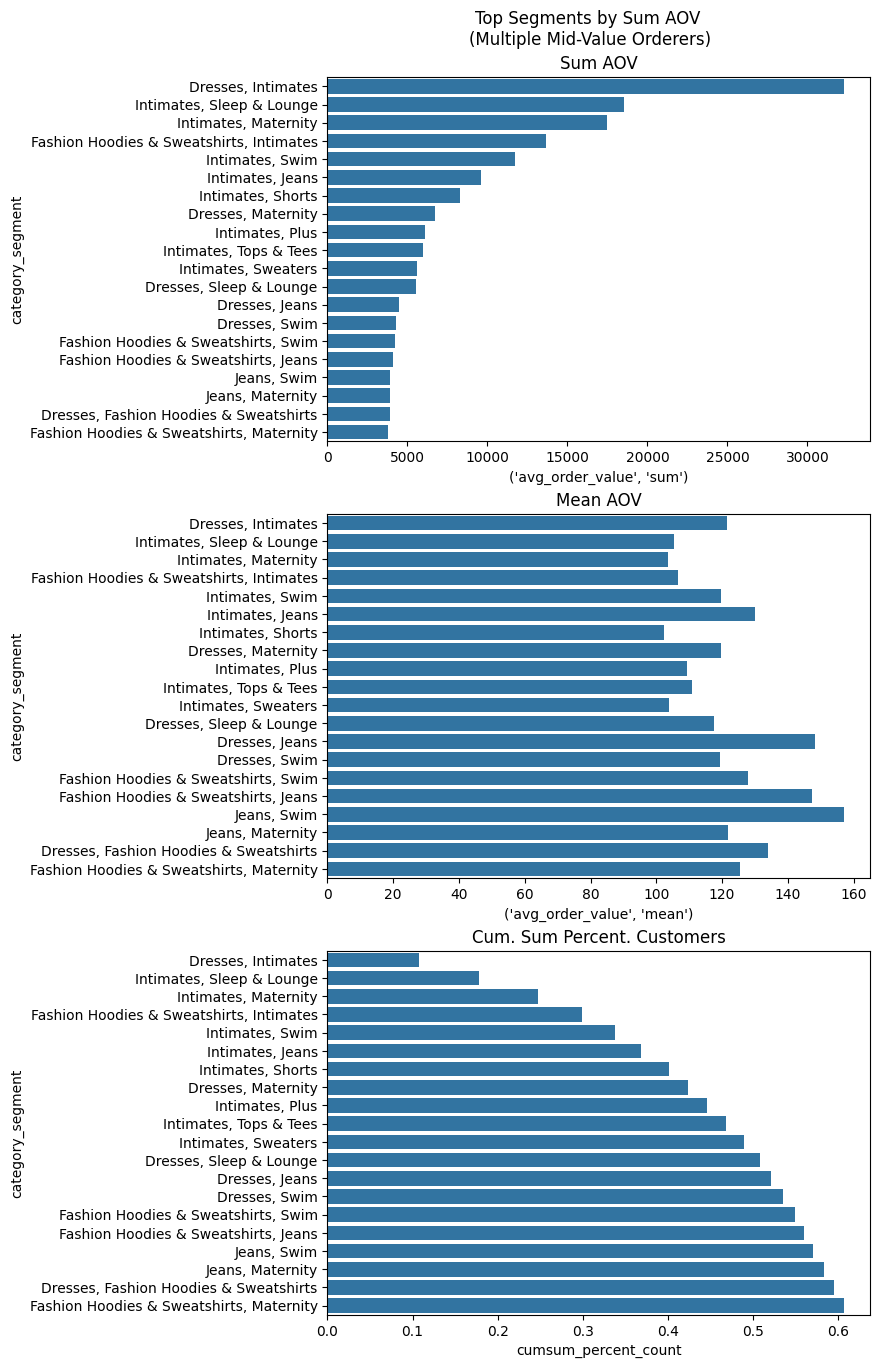

In [560]:
bool_idx = (users_enriched_new.gender=='F') & (users_enriched_new.order_value_segment=='Ordering Multiple Mid-Value Items')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(Multiple Mid-Value Orderers)')

#### Mid-/High-Value Orderers

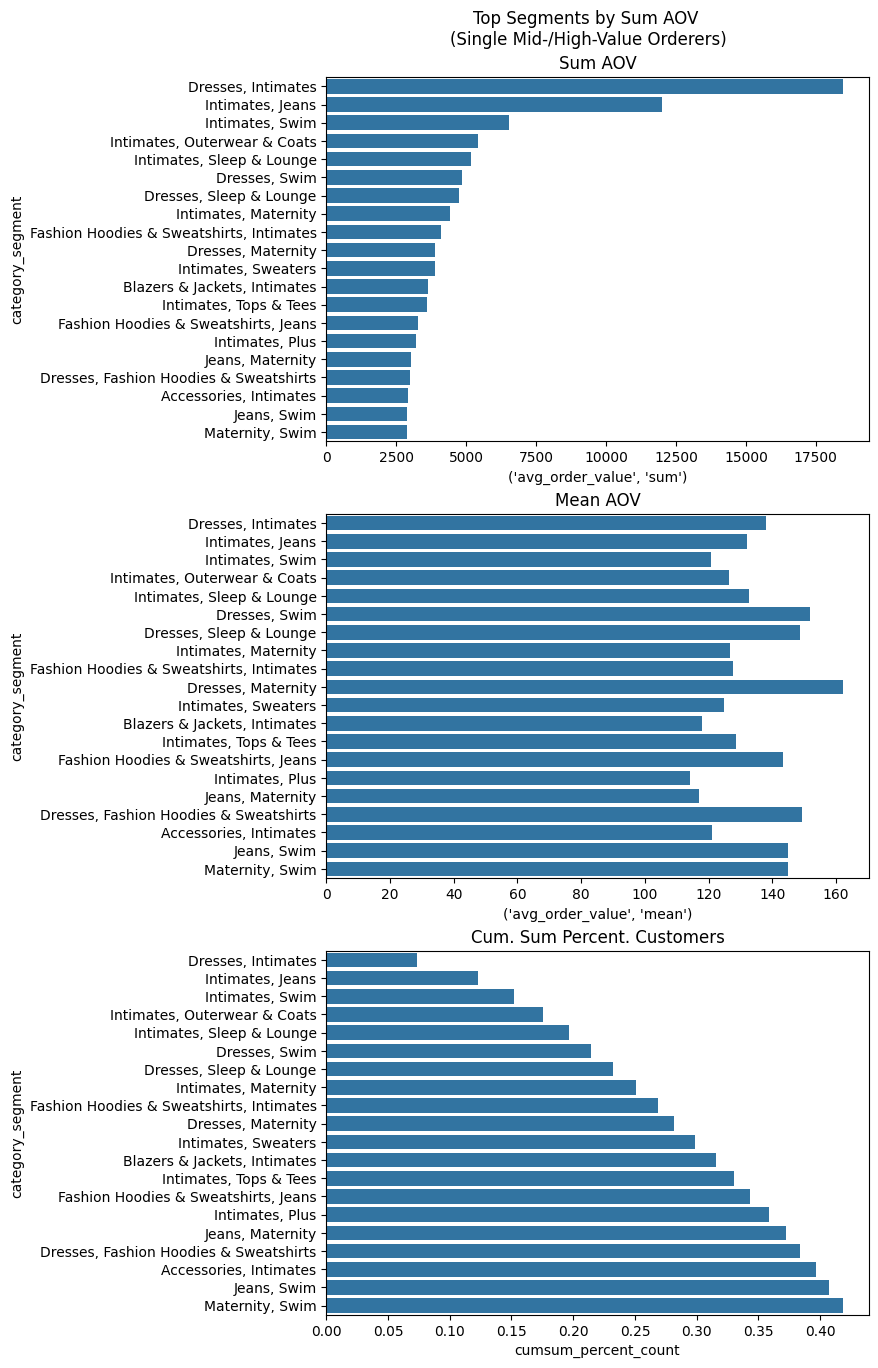

In [561]:
bool_idx = (users_enriched_new.gender=='F') & (users_enriched_new.order_value_segment=='Ordering Mid-/High-Value Items')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(Single Mid-/High-Value Orderers)')

#### High-Value Orderers

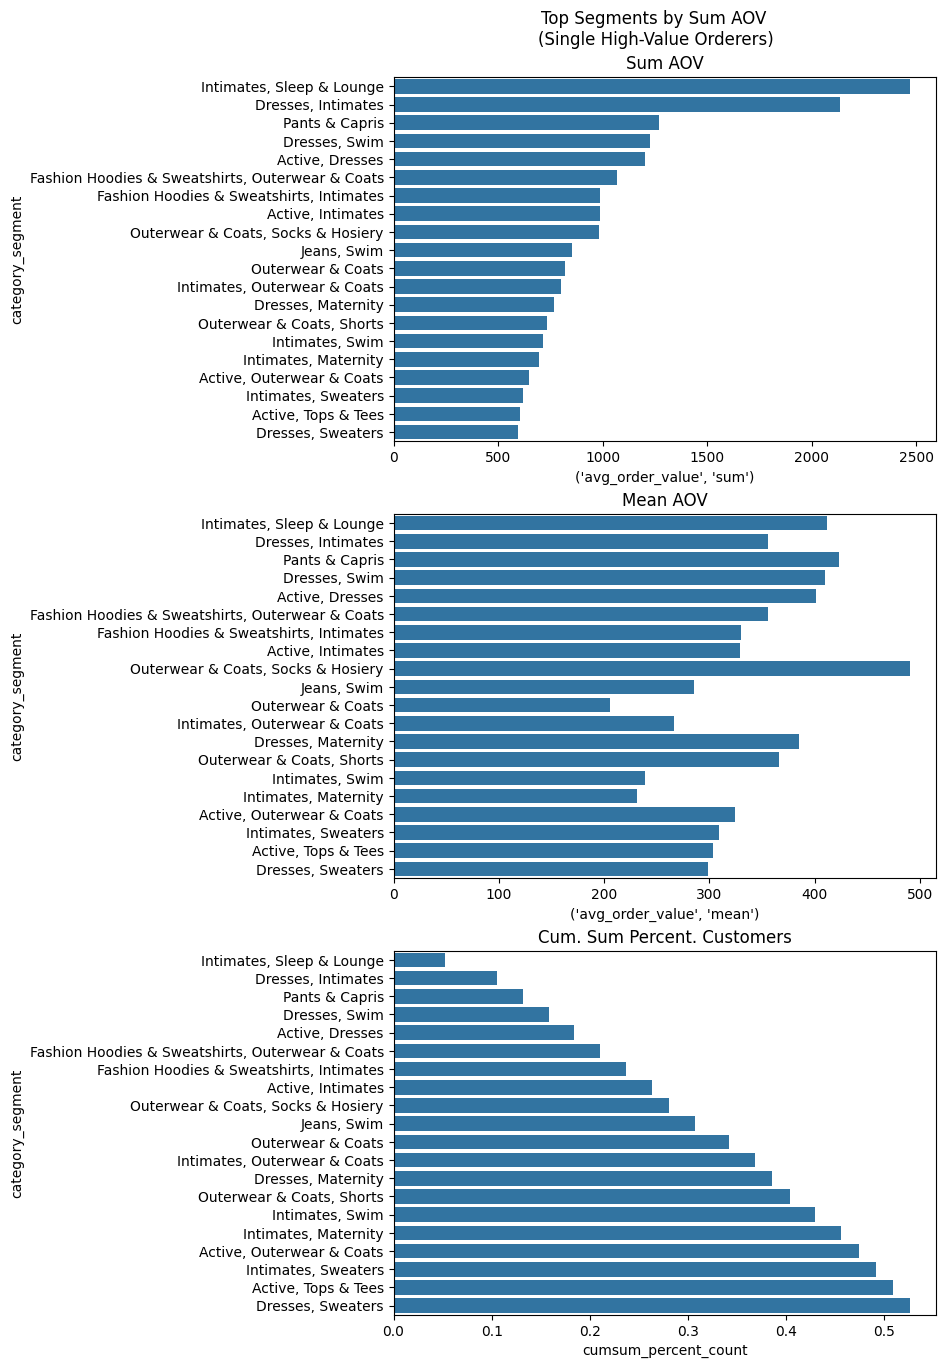

In [562]:
bool_idx = (users_enriched_new.gender=='F') & (users_enriched_new.order_value_segment=='Ordering High Value Items')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(Single High-Value Orderers)')

#### Low-Value Orderers

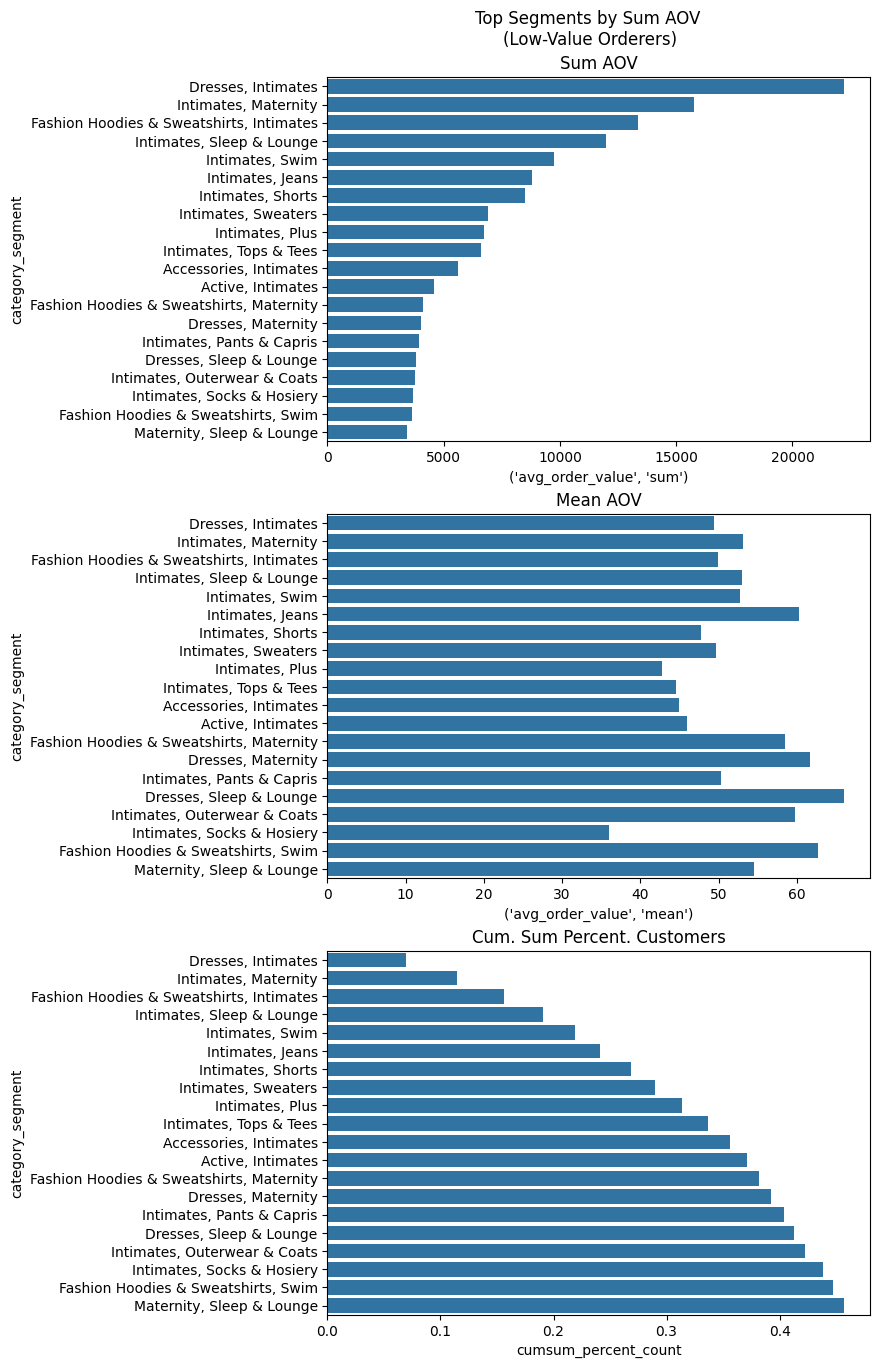

In [563]:
bool_idx = (users_enriched_new.gender=='F') & (users_enriched_new.order_value_segment=='Ordering Low Value')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(Low-Value Orderers)')

## Male Customers

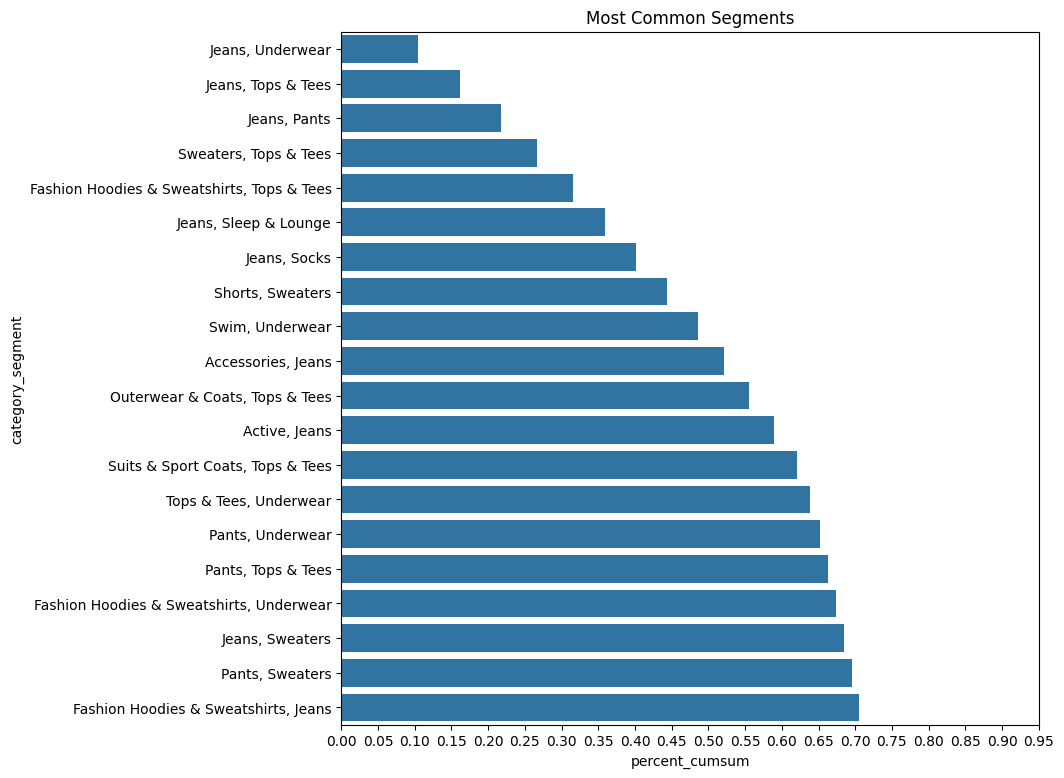

In [564]:
category_segment_aggs = plot_category_segments(recommendations_segmented_m)

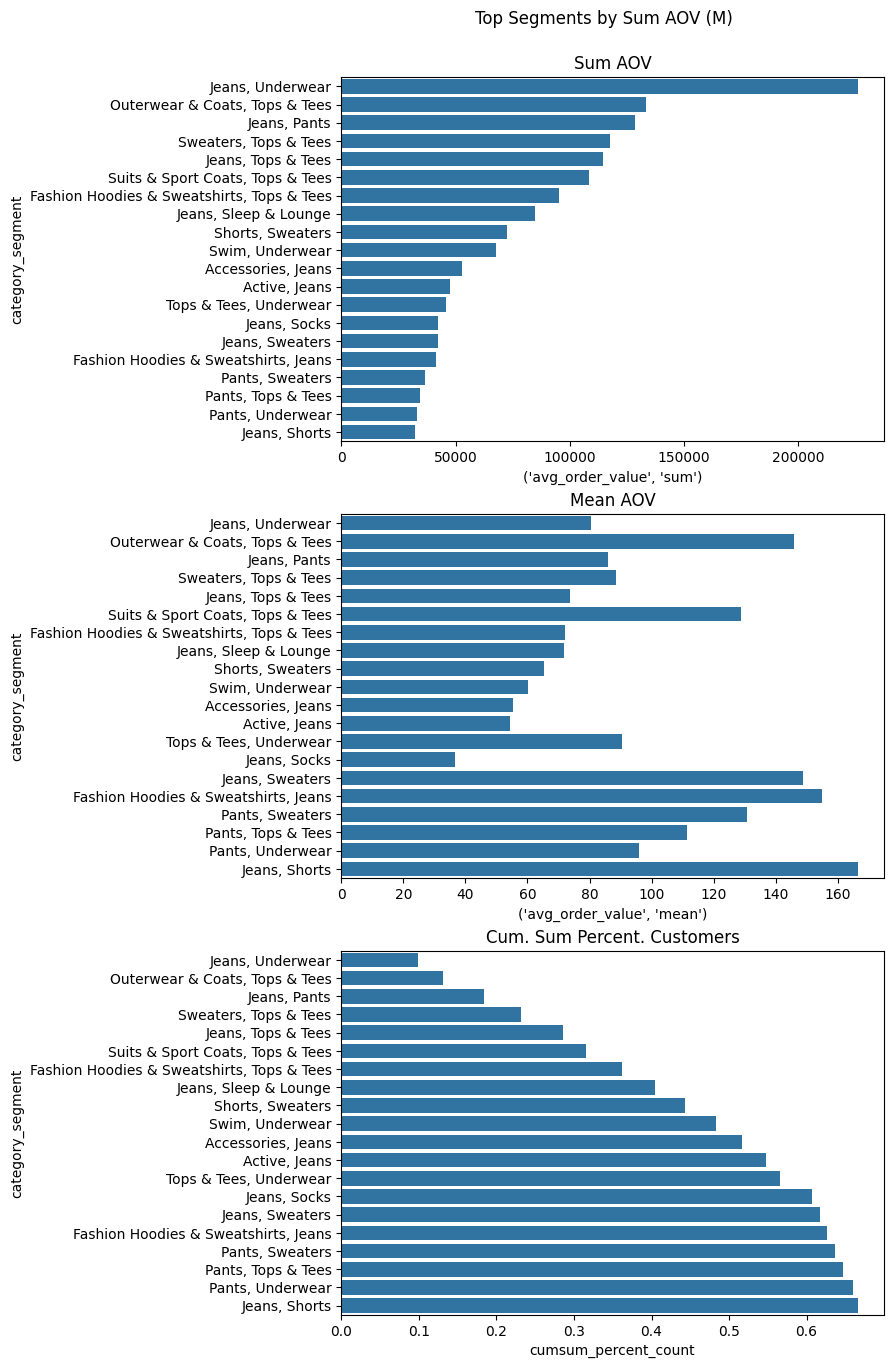

In [565]:
plot_category_segments_aov(users_enriched_new.loc[users_enriched_new.gender=='M'], title_suffix='(M)')

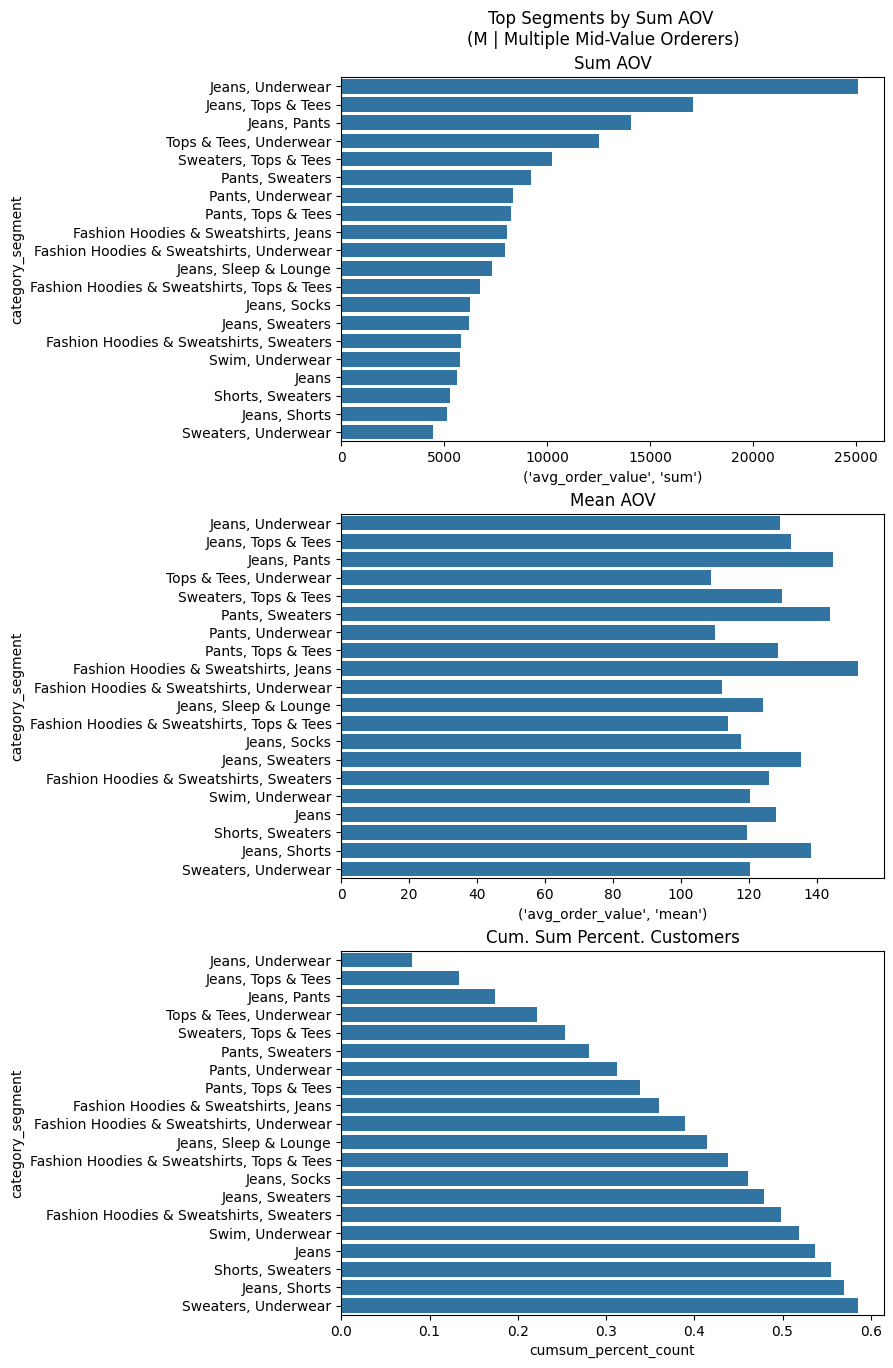

In [566]:
bool_idx = (users_enriched_new.gender=='M') & (users_enriched_new.order_value_segment=='Ordering Multiple Mid-Value Items')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(M | Multiple Mid-Value Orderers)')

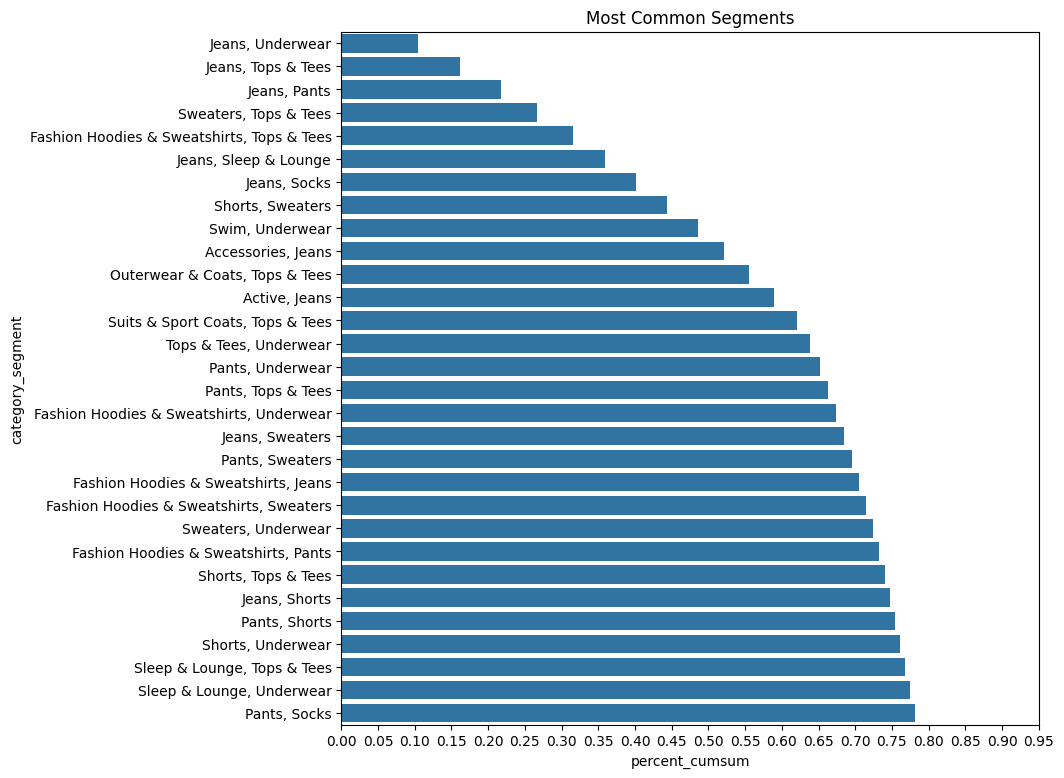

In [567]:
category_segment_aggs = plot_category_segments(recommendations_segmented_m, top_k=30)

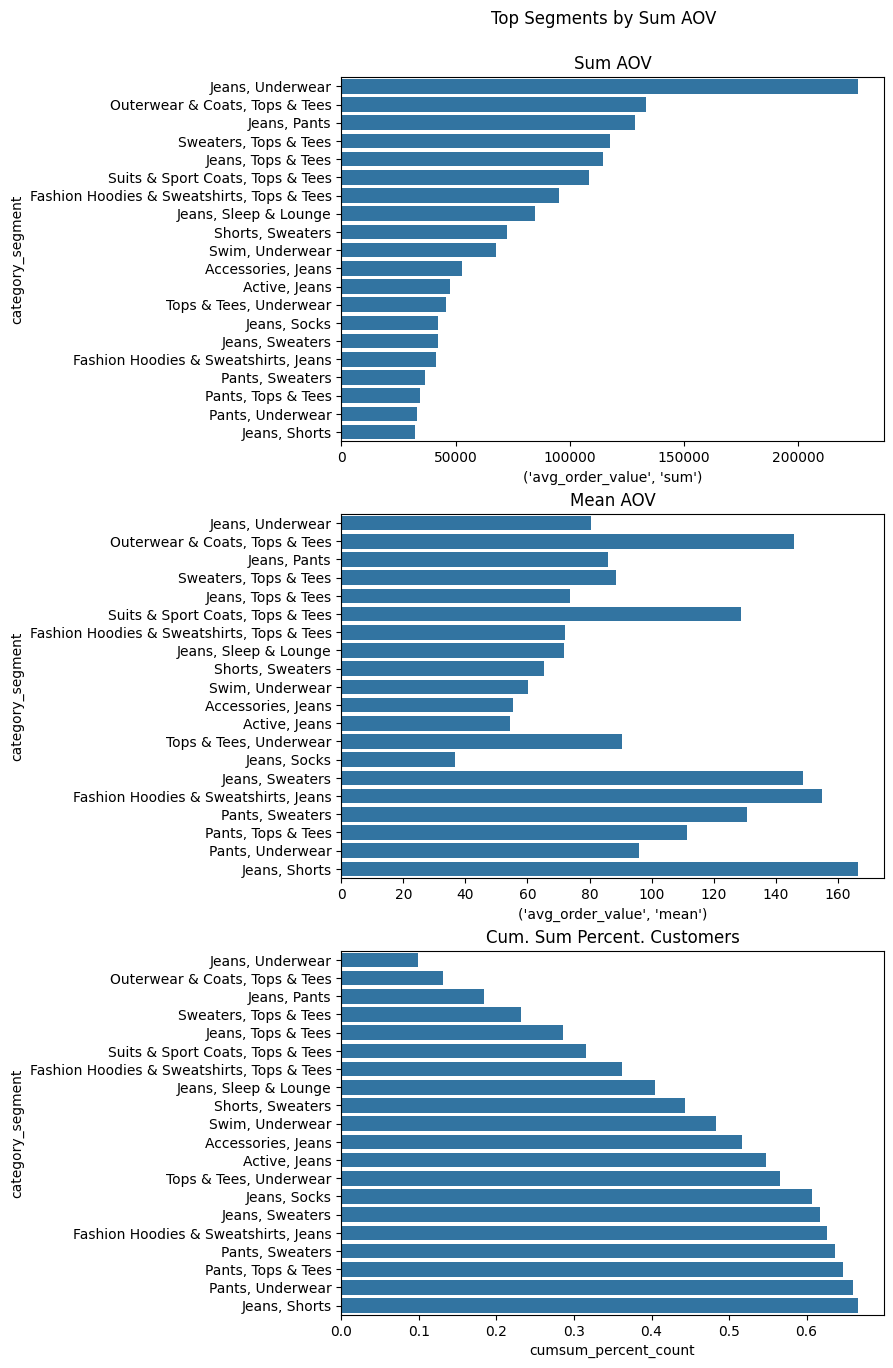

In [568]:
bool_idx = (users_enriched_new.gender=='M')
plot_category_segments_aov(users_enriched_new.loc[bool_idx])

### Drill-Down by Order Value Segment

#### Multiple Mid-Value Orderers

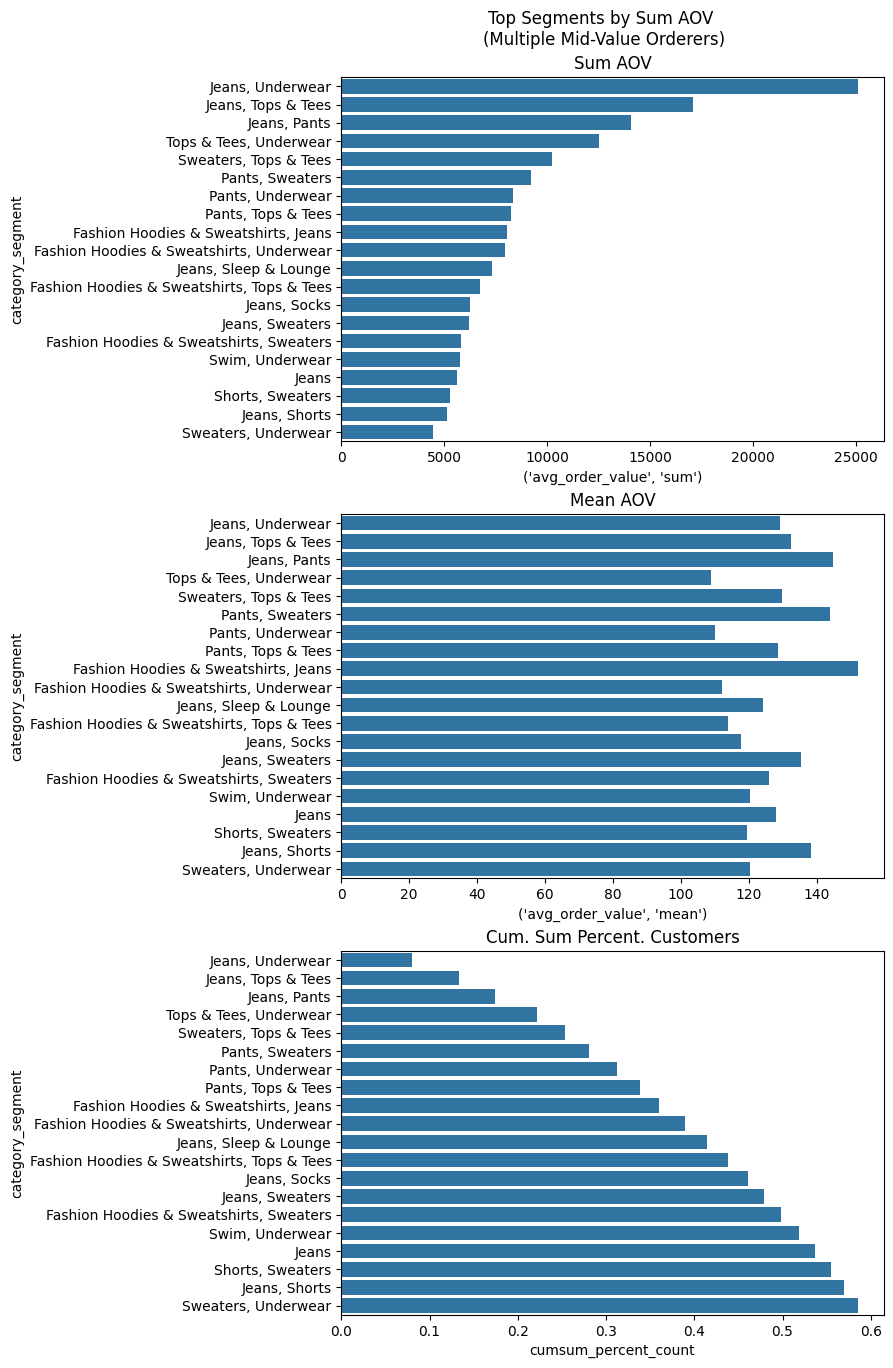

In [569]:
bool_idx = (users_enriched_new.gender=='M') & (users_enriched_new.order_value_segment=='Ordering Multiple Mid-Value Items')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(Multiple Mid-Value Orderers)')

#### High-Value Orderers

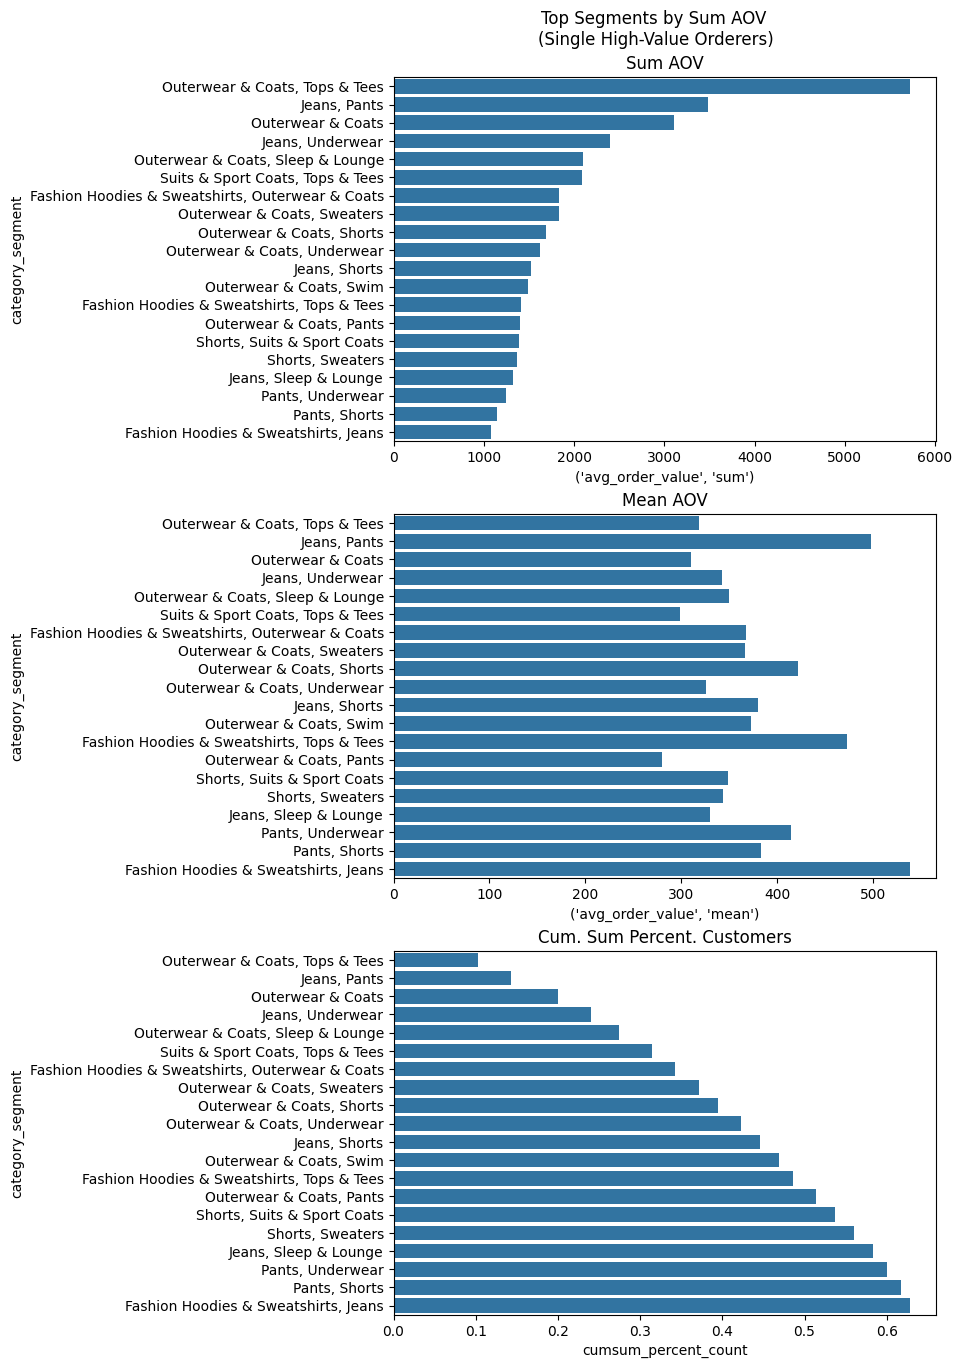

In [570]:
bool_idx = (users_enriched_new.gender=='M') & (users_enriched_new.order_value_segment=='Ordering High Value Items')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(Single High-Value Orderers)')

#### Mid-/High-Value Orderers 

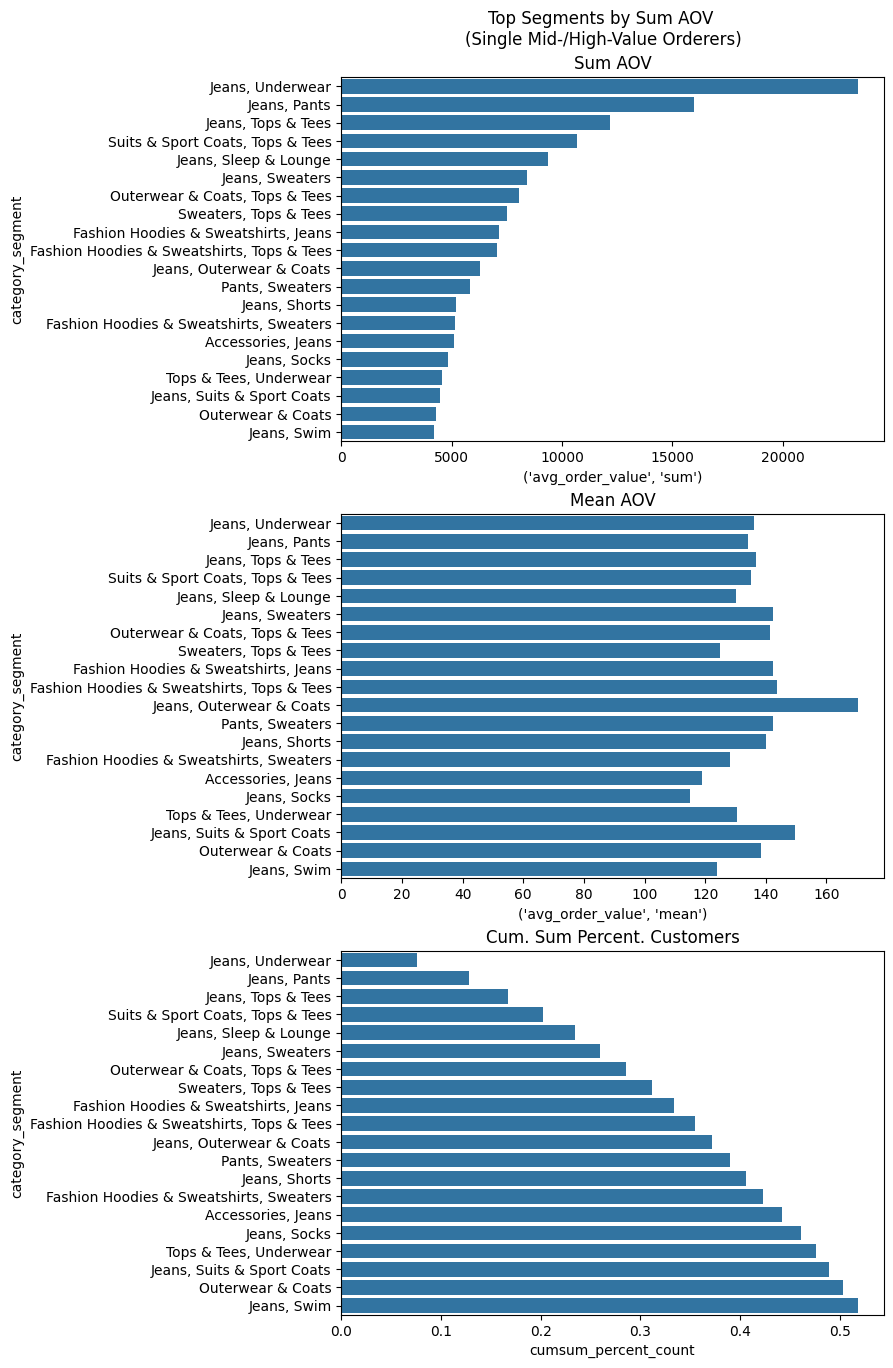

In [571]:
bool_idx = (users_enriched_new.gender=='M') & (users_enriched_new.order_value_segment=='Ordering Mid-/High-Value Items')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(Single Mid-/High-Value Orderers)')

#### Low-Value Orderers 

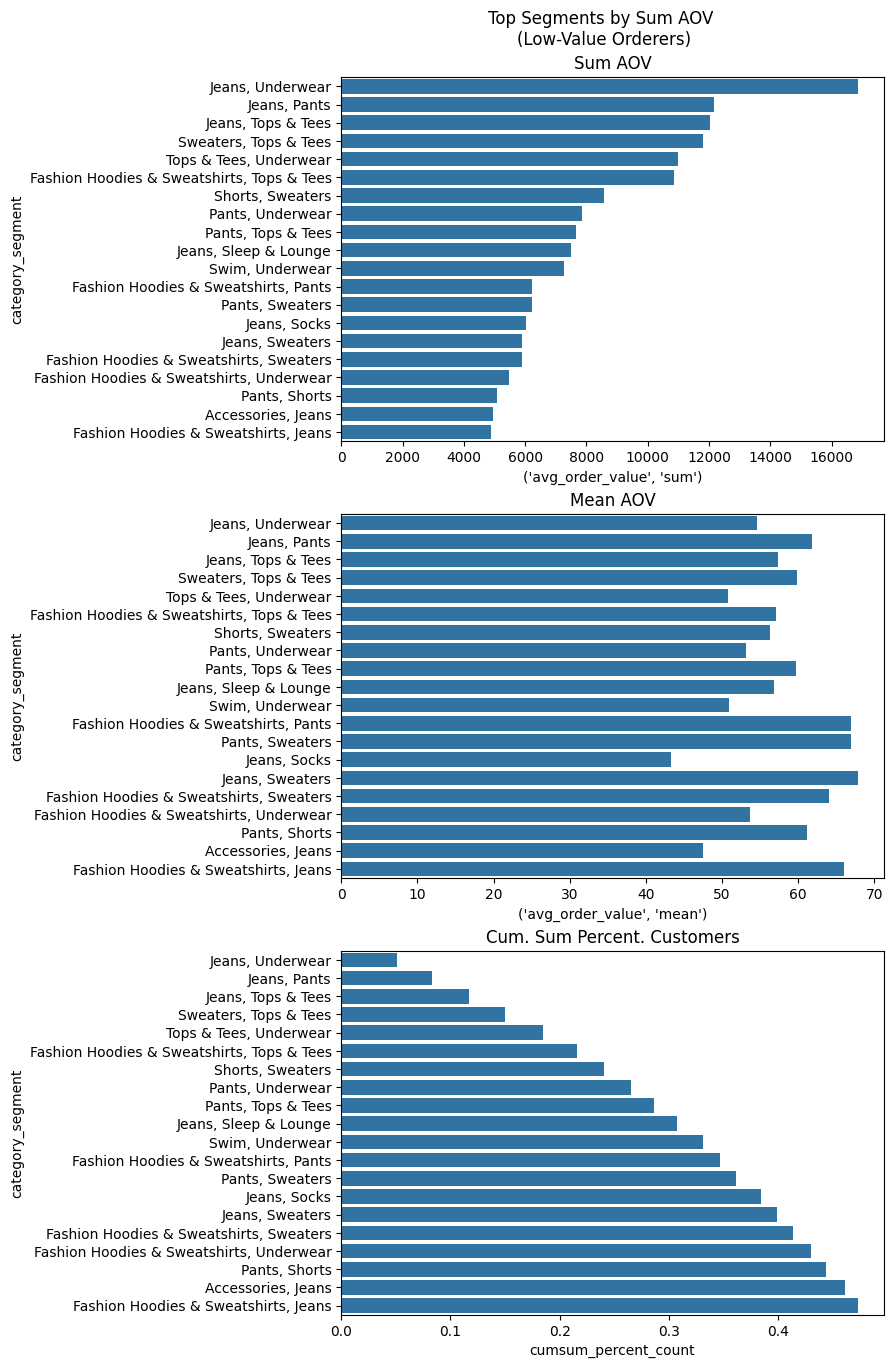

In [572]:
bool_idx = (users_enriched_new.gender=='M') & (users_enriched_new.order_value_segment=='Ordering Low Value')
plot_category_segments_aov(users_enriched_new.loc[bool_idx], title_suffix='\n(Low-Value Orderers)')